In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_url = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"

In [3]:
df = pd.read_csv(data_url, sep=",")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [4]:
x = df.households.values.reshape(-1, 1)
y = df.total_rooms.values.reshape(-1,1)

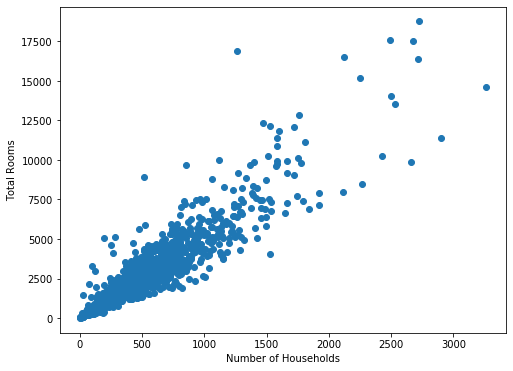

In [5]:
plt.figure(1, figsize=(8, 6))
plt.scatter(x[::10], y[::10])
plt.xlabel('Number of Households')
plt.ylabel('Total Rooms')
plt.show();

$$h(x) = x w + b$$

In [6]:
def get_params(shape):
    np.random.seed(7)
    params = {
    'W':tf.Variable(np.random.randn(*shape), dtype = tf.float32),
    'b':tf.Variable(np.zeros((1, shape[1])), dtype = tf.float32)
    }
    return params

In [7]:
params = get_params([x.shape[1], y.shape[1]])

In [8]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    result = sess.run(params)
    print(result)

{'W': array([[1.6905257]], dtype=float32), 'b': array([[0.]], dtype=float32)}


In [9]:
def linear(x, params):
    h = tf.add(tf.matmul(x, params['W']),params['b'])
    return h

In [10]:
def get_cost(x, y, model, params, lambd = 0, kind = 'MSE'):
    h= model(x, params)
    if kind == 'MSE':
        J = (h-y)**2
    elif kind == 'crossentropy':
        epsilon = 1e-20
        J = -(y*tf.math.log(h +epsilon) + (1-y)*tf.math.log(1-h+epsilon))
    J = tf.math.reduce_mean(J)+ ((lambd/2)*tf.math.reduce_sum(params['W']**2)) 
    return J

In [11]:
def train(inp, out, model, epochs = 100, lr= 1e-3, lambd = 0, kind = 'MSE'):
    x = tf.placeholder(tf.float32, shape = (None, inp.shape[1]))
    y = tf.placeholder(tf.float32, shape = (None, out.shape[1]))
    params = get_params([x.shape[1], y.shape[1]])
    costs = []
    cost = get_cost(x, y, model, params, lambd, kind)
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)
    init=tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            c, _ = sess.run([cost, optimizer], feed_dict={x: inp, y:out})
            
            if epoch%(epochs//10) == 0:
                print('Cost at epoch ' + str(epoch), c)
            if epoch%5 == 0:
                costs.append(c)
                
        params = sess.run(params)
    
    return costs, params
        
    

In [12]:
costs, params = train(x, y, model = linear, lr= 1e-1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Cost at epoch 0 5796791.5
Cost at epoch 10 3375282.5
Cost at epoch 20 1827685.6
Cost at epoch 30 1049884.0
Cost at epoch 40 781680.2
Cost at epoch 50 738789.5
Cost at epoch 60 744360.2
Cost at epoch 70 744411.25
Cost at epoch 80 740684.75
Cost at epoch 90 738932.8


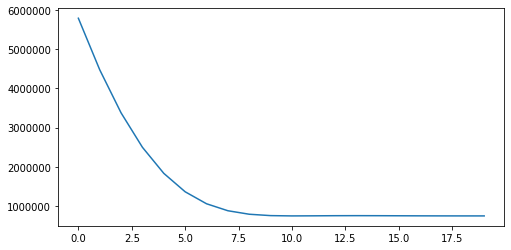

In [13]:
plt.figure(2, figsize = (8, 4))
plt.plot(costs)
plt.show();

In [14]:
with tf.Session() as sess:
    inp = tf.constant(x, dtype = tf.float32)
    prediction = sess.run(linear(inp, params))


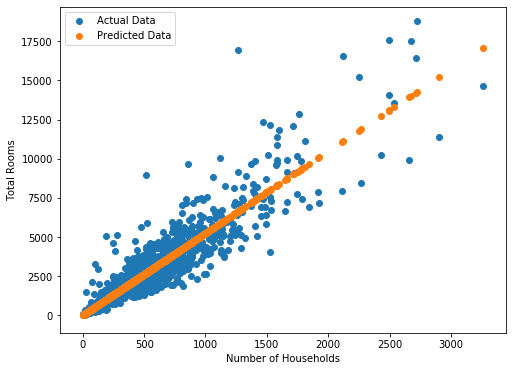

In [15]:
plt.figure(3, figsize = (8, 6))
plt.scatter(x[::10], y[::10], label = 'Actual Data')
plt.scatter(x[::10], prediction[::10], label = 'Predicted Data')
plt.legend()
plt.xlabel('Number of Households')
plt.ylabel('Total Rooms');
plt.show();

In [16]:
df = pd.read_csv('datasets/heart.csv')

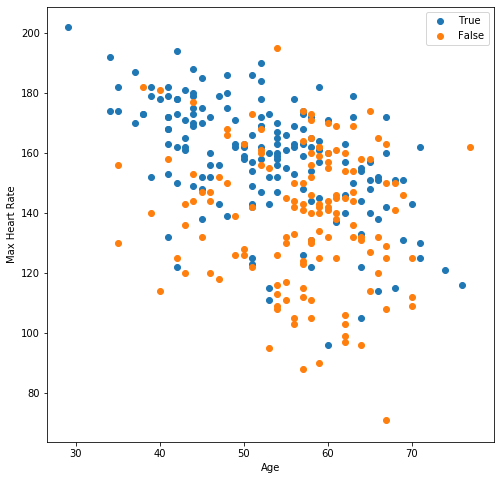

In [17]:
plt.figure(figsize = (8, 8))

for target in df.target.unique():
    mask = df.target == target
    plt.scatter(df.age[mask], df.thalach[mask], label = True if target == 1 else False)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Max Heart Rate');

In [18]:
def norm_factors(inp):
    u = inp.mean(axis = 0, keepdims = True)
    return  u, inp.std(axis = 0)

In [19]:
x = np.array([df.age.values,df.thalach.values]).T
y = df.target.values.reshape(-1, 1)

In [20]:
u, s = norm_factors(x)
x_n = (x-u)/s

In [21]:
def logistic(inp, params):
    
    z = linear(inp, params)
    h = tf.nn.sigmoid(z)
    return h

In [22]:
costs, params = train(x_n, y, model = logistic, lr= 1e-2, kind = 'crossentropy', epochs = 1000)

Cost at epoch 0 1.3411057
Cost at epoch 100 0.74581605
Cost at epoch 200 0.6079313
Cost at epoch 300 0.5922655
Cost at epoch 400 0.59046984
Cost at epoch 500 0.59023476
Cost at epoch 600 0.59019905
Cost at epoch 700 0.59019405
Cost at epoch 800 0.59019345
Cost at epoch 900 0.59019357


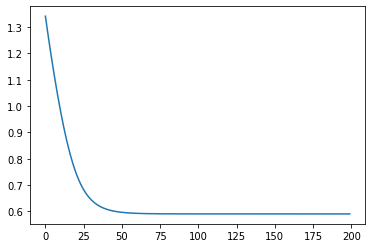

In [23]:
plt.plot(costs);

In [24]:
def get_grid(x):
    a = np.linspace(x[:, 0].min() -1, x[:, 0].max() +1, 1000)
    b = np.linspace(x[:, 1].min() -1, x[:, 1].max()+1, 1000)
    xx, yy = np.meshgrid(a, b, sparse=False)
    zz = np.stack((xx,yy), axis =2)
    
    u, s = norm_factors(x)
    inp = zz.reshape(-1, 2)
    inp_n = (inp-u)/s
    return xx, yy, inp_n

In [25]:
xx, yy, inp_n = get_grid(x)

In [26]:
with tf.Session() as sess:
    inp = tf.constant(inp_n, dtype = tf.float32)
    prediction = sess.run(logistic(inp, params))>0.5



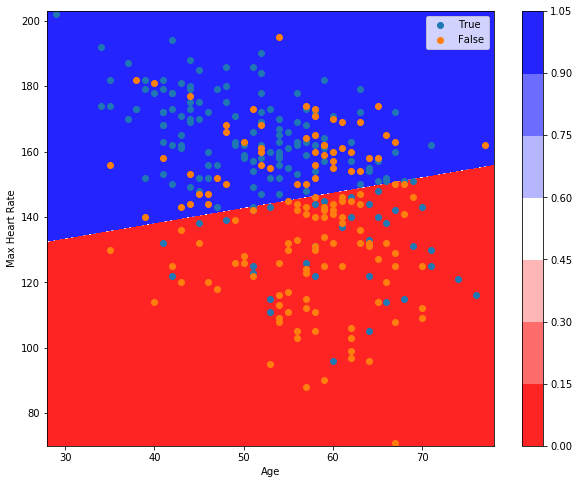

In [27]:
plt.figure(figsize = (10, 8))

plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap = 'bwr_r')
plt.colorbar()

for target in df.target.unique():
    mask = df.target == target
    plt.scatter(df.age[mask], df.thalach[mask], label = True if target == 1 else False)
plt.legend()

plt.xlabel('Age')
plt.ylabel('Max Heart Rate');

In [28]:
def add_polynomials(x, order = 5):
    
    x_new = list()
    for i in range(1, order+1):
        for j in range(i+1):
            x_new.append((x[:,0]** (i-j)) *(x[:,1]** (j))) 
    x_new = np.array(x_new)
    
    
    return x_new.T

In [29]:
x_p = add_polynomials(x_n) 

In [30]:
u_p, s_p = norm_factors(x_p)

In [31]:
costs, params = train((x_p - u_p)/s_p, y, model = logistic, lr= 1e-2, kind = 'crossentropy', epochs = 10000, lambd = 1e-2)

Cost at epoch 0 1.2172059
Cost at epoch 1000 0.5668068
Cost at epoch 2000 0.5667986
Cost at epoch 3000 0.5667986
Cost at epoch 4000 0.5667986
Cost at epoch 5000 0.5667986
Cost at epoch 6000 0.5667986
Cost at epoch 7000 0.5667986
Cost at epoch 8000 0.5667986
Cost at epoch 9000 0.56680137


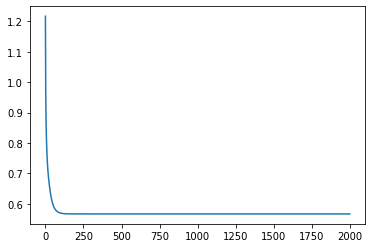

In [32]:
plt.plot(costs)

In [33]:
inp_p = add_polynomials(inp_n)

In [34]:
with tf.Session() as sess:
    inp = tf.constant((inp_p - u_p)/s_p, dtype = tf.float32)
    prediction = sess.run(logistic(inp, params))>0.5




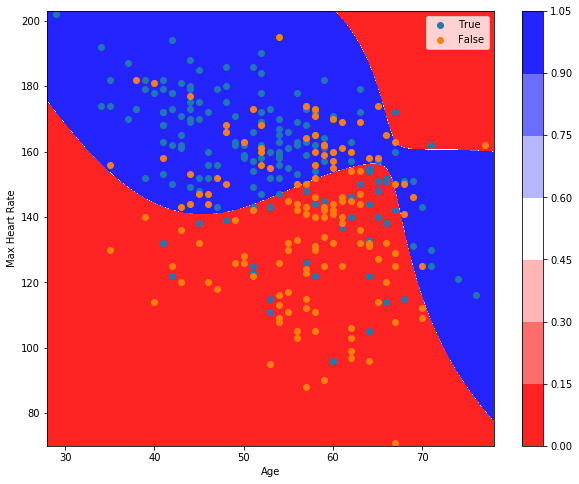

In [35]:
plt.figure(figsize = (10, 8))

plt.contourf(xx, yy, prediction.reshape(xx.shape), cmap = 'bwr_r')
plt.colorbar()

for target in df.target.unique():
    mask = df.target == target
    plt.scatter(df.age[mask], df.thalach[mask], label = True if target == 1 else False)
plt.legend()

plt.xlabel('Age')
plt.ylabel('Max Heart Rate');

In [36]:
params

{'W': array([[-0.4898672 ],
        [ 0.990799  ],
        [ 0.170752  ],
        [-0.35882705],
        [-0.06272779],
        [ 0.47831014],
        [-0.05925216],
        [-0.08868702],
        [-0.1800433 ],
        [-0.17419758],
        [-0.38650352],
        [-0.11621823],
        [ 0.0599663 ],
        [-0.15884355],
        [ 0.00339448],
        [-0.18220668],
        [-0.11261298],
        [ 0.10902244],
        [ 0.001259  ],
        [-0.08569542]], dtype=float32),
 'b': array([[0.23800093]], dtype=float32)}